In [1]:
import xarray as xr
import pandas as pd
import os
import matplotlib as mpl
import matplotlib.pyplot as plt
import pathlib
import numpy as np
from my_library.track_analyses import helpers
import dask
dask.config.set(**{'array.slicing.split_large_chunks': True})
import global3d_track as g3d
src = g3d.scripts.src

In [2]:
datadir = pathlib.Path(f'/work/bb1153/b382635/plots/tracked_results_2025/dataset_paper/results_data/acp_submission/')
list(datadir.glob("dcc_statisticsV3/*.nc"))

[PosixPath('/work/bb1153/b382635/plots/tracked_results_2025/dataset_paper/results_data/acp_submission/dcc_statisticsV3/b12s50.nc'),
 PosixPath('/work/bb1153/b382635/plots/tracked_results_2025/dataset_paper/results_data/acp_submission/dcc_statisticsV3/b16s50.nc'),
 PosixPath('/work/bb1153/b382635/plots/tracked_results_2025/dataset_paper/results_data/acp_submission/dcc_statisticsV3/b3s50.nc'),
 PosixPath('/work/bb1153/b382635/plots/tracked_results_2025/dataset_paper/results_data/acp_submission/dcc_statisticsV3/b2s50.nc'),
 PosixPath('/work/bb1153/b382635/plots/tracked_results_2025/dataset_paper/results_data/acp_submission/dcc_statisticsV3/b13s50.nc'),
 PosixPath('/work/bb1153/b382635/plots/tracked_results_2025/dataset_paper/results_data/acp_submission/dcc_statisticsV3/b7s50.nc'),
 PosixPath('/work/bb1153/b382635/plots/tracked_results_2025/dataset_paper/results_data/acp_submission/dcc_statisticsV3/b8s50.nc'),
 PosixPath('/work/bb1153/b382635/plots/tracked_results_2025/dataset_paper/result

In [7]:
files = list(datadir.glob("dcc_statisticsV3/*.nc"))[:]

In [11]:
# which cores sat above ~4km?
# files = list(datadir.glob("dcc_statistics/*.nc"))
stats = xr.open_mfdataset(files, concat_dim='system', combine='nested')
stats['lifetime_hours'] = stats['lifetime'] / np.timedelta64(1, "h")
systems = stats.system.values

In [20]:
# load systems
fdir = f'/work/bb1153/b382635/data/track_statistics/updraft_ice_only/amazon/system-wise/fcsfirst/'
df = pd.read_csv(datadir / 'system_validity.csv', index_col='system_id')
had_upper_level_cores = df.index[np.logical_and(df.index.isin(systems), df.n_cores_above_freezing>1)]
variables = ['core_mean_w','core_bh','cloud_area']
ds = helpers.load_stats(fdir, variables, sidx_list=had_upper_level_cores.values)

### understand tracked upper level cores

#### how do their stats compare?

In [12]:
upper = stats.sel(system=had_upper_level_cores.values)
lower = stats.sel(system=[s for s in stats.system.values if s not in had_upper_level_cores])

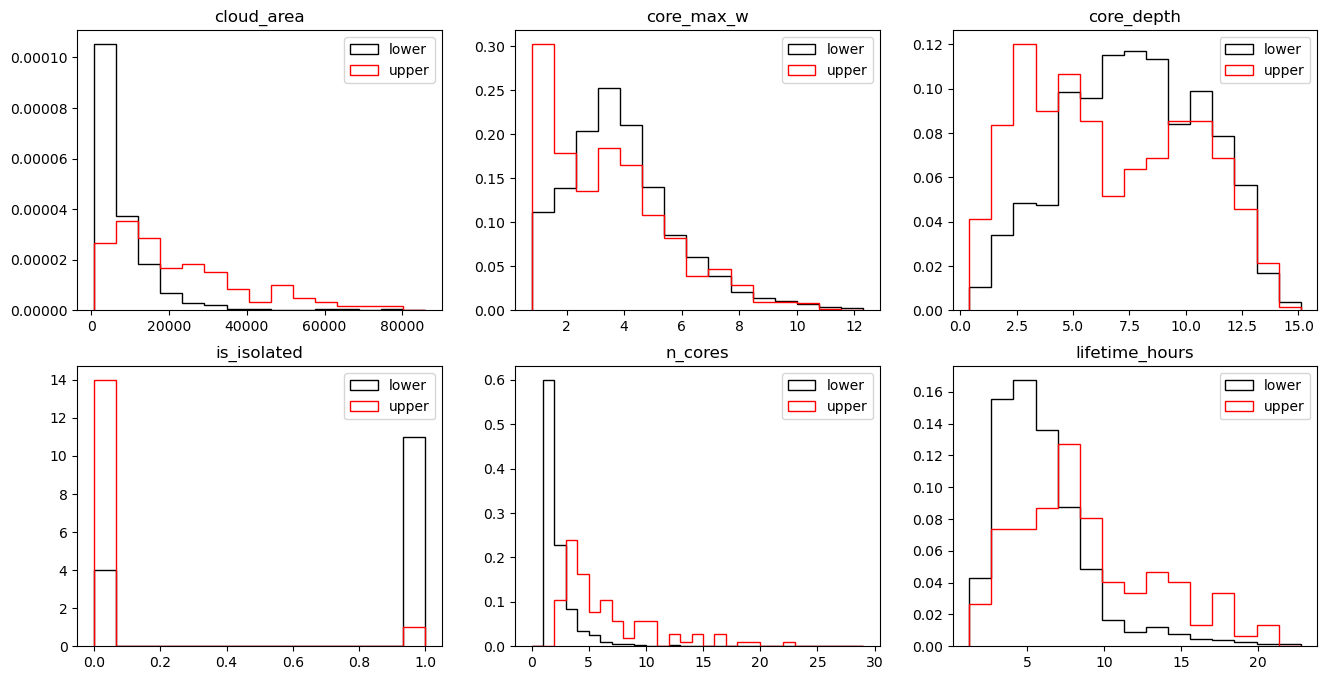

In [14]:
vars_to_plot = ['cloud_area','core_max_w','core_depth','is_isolated','n_cores','lifetime_hours']

fig, axs = plt.subplots(2,3, figsize=(16,8))

for ax, var in zip(axs.flat, vars_to_plot):
    if 'interp_time' in upper[var].dims:
        upper_vals = upper[var].max('interp_time')
        lower_vals = lower[var].max('interp_time')
    else:
        upper_vals = upper[var]
        lower_vals = lower[var]
        
    upper_vals = upper_vals.values.ravel()
    lower_vals = lower_vals.values.ravel()

    if var=='n_cores':
        bins = np.arange(0,30,1)
    else:
        bins = 15

    # view
    n, bins, patches = ax.hist(lower_vals, bins=bins, histtype='step', ec='k', density=True, label='lower')
    ax.hist(upper_vals, bins=bins, histtype='step', ec='r', density=True, label='upper')
    ax.set_title(var)
    ax.legend()

#### this example has many cores, and its the later ones that were upper level

In [21]:
ex = ds.sel(system=12522)

In [22]:
# get time of onset for each core
ex_w = ex[['core_mean_w','core_bh']].dropna('core', how='all')
t0_idx = ex_w.core_mean_w.notnull().any("level_full").argmax("time")
t0 = ex_w["time"].isel(time=t0_idx)

Text(0.5, 0, 'vertical velocity [m/s]')

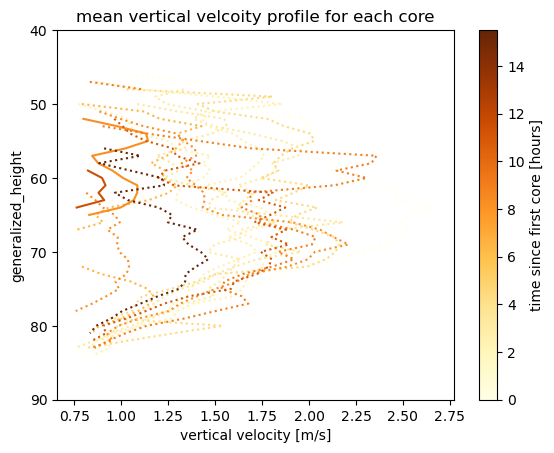

In [23]:
# plot cores
fig, ax = plt.subplots()
cmap = plt.get_cmap('YlOrBr')

# colour by core start time
t0_num = (t0 - t0.min()) / np.timedelta64(60, "m")
norm = mpl.colors.Normalize(vmin=t0_num.min().values, vmax=t0_num.max().values)

for i,c, in enumerate(ex_w.core):
    # color
    col = cmap(norm(t0_num.sel(core=c).values))
    # data
    max_w = ex_w.core_mean_w.sel(core=c).mean('time')
    ls = ':'
    if ex_w.sel(core=c).core_bh.min('time')>4000:
        ls = '-'
    max_w.plot(ax=ax, c=col, y='level_full', ls=ls)
ax.set_ylim(90,40)

# colorbar
sm = plt.cm.ScalarMappable(norm=norm, cmap=cmap)
sm.set_array([])
fig.colorbar(sm, ax=ax, label="time since first core [hours]")
ax.set_title('mean vertical velcoity profile for each core')
ax.set_xlabel('vertical velocity [m/s]')

#### typically, we see the following

In [24]:
# core onset times
t0_idx = ds.core_mean_w.notnull().any("level_full").argmax("time")
t0 = ds.time.isel(time=t0_idx.compute()).where(ds.core_bh.max('time')>0).compute()
# time since first core
time_since_first = (t0 - t0.min('core',skipna=True)) / np.timedelta64(1, "m")

In [25]:
# calculate all onset times
core_base_heights = ds.core_bh.min('time').compute()
was_upper = core_base_heights>4000
all_times = time_since_first.where(was_upper).compute()

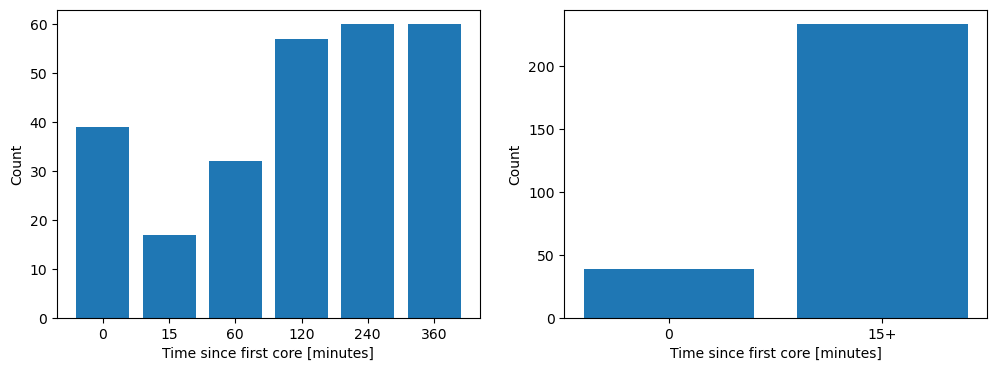

In [26]:
# data
vals = all_times.values.ravel()
vals = vals[~np.isnan(vals)]

# view
fig, axs = plt.subplots(1,2, figsize=(12,4))

ax = axs[0]
bins = np.array([0, 15, 60, 120, 240, 360, 12 * 60])
counts, _ = np.histogram(vals, bins=bins)
x = np.arange(len(counts))
ax.bar(x, counts, width=0.8)
ax.set_xticks(x)
ax.set_xticklabels(bins[:-1])

ax = axs[1]
bins = np.array([0, 15, 24 * 60])
counts, _ = np.histogram(vals, bins=bins)
x = np.arange(len(counts))
ax.bar(x, counts, width=0.8)
ax.set_xticks(x)
ax.set_xticklabels(['0','15+'])

for ax in axs:
    ax.set_xlabel("Time since first core [minutes]")
    ax.set_ylabel("Count")

## -> most (~60%) were secondary cores

In [27]:
# view heights by time since first core

scat_ds = xr.Dataset({'t_since_first':all_times/60,
                      'base_height':core_base_heights.where(was_upper)/1000,
                      'mean_w':ds.core_mean_w.max('level_full').mean(('time')).where(was_upper),
                     })
scat_ds['system_idx'] = ('system', np.linspace(0,scat_ds.system.size,scat_ds.system.size))
scat_ds["system_idx"] = scat_ds.system_idx.broadcast_like(scat_ds.base_height)

# flatten & mask
x = scat_ds.base_height.values.ravel()
y = scat_ds.t_since_first.values.ravel()
c = scat_ds.mean_w.values.ravel()
mask = ~np.isnan(x) & ~np.isnan(y)

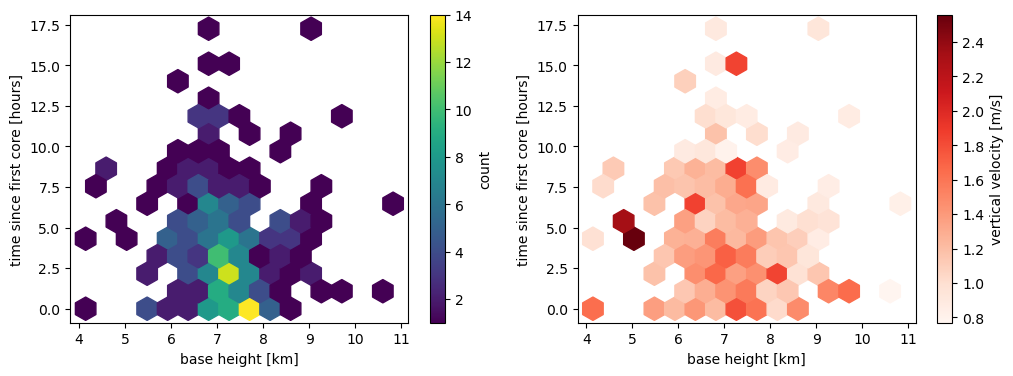

In [28]:
# plot
fig, axs = plt.subplots(1,2,figsize=(12,4))

ax = axs[0]
hb = ax.hexbin(x[mask], y[mask], gridsize=15, mincnt=1, cmap='viridis')
ax.set(xlabel="base height [km]", ylabel="time since first core [hours]",)
cbar = fig.colorbar(hb, ax=ax)
cbar.set_label("count")

ax = axs[1]
hb = ax.hexbin(x[mask], y[mask], gridsize=15, mincnt=1, C=c[mask], reduce_C_function=np.mean, 
              cmap='Reds')
ax.set(xlabel="base height [km]", ylabel="time since first core [hours]",)
cbar = fig.colorbar(hb, ax=ax)
cbar.set_label("vertical velocity [m/s]")